# Class representations in image tokens

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import seaborn as sns
sns.set_style("whitegrid")
import torch


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

__TO-DO__: Define your path to the project folder and ImageNet-S dataset here:

In [3]:
PROJ_PATH = []
DATASET_PATH = [] 
CIFAR_PATH = []

In [5]:
# Define paths
PROJ_PATH = Path(PROJ_PATH)
DATASET_PATH = Path(DATASET_PATH)
RES_PATH = PROJ_PATH / 'results'

# Create figures path
(RES_PATH / 'figures').mkdir(parents=True, exist_ok=True)

__Mapping of model names__

In [6]:
MODEL_MAP = {
    'vit_b_32': 'ViT-B/32',
    'vit_b_16': 'ViT-B/16',
    'vit_large_16': 'ViT-L/16',
    'vit_miil_16': 'ViT-B/16-MIIL',
    'vit_cifar_16': 'ViT-B/16-CIFAR',
    'deit_ensemble_16': 'ViT-B/16-Refinement',
    'vit_gap_16': 'ViT-B/16-GAP',
}

## Class representations in image tokens

We measure the __class identifiability rate__, which we quantified as the percentage of tokens that contain a class identifiability score of 1. 

We also measure the percentage of images that contain at least one image token with an identifiability score of 1 in the last block.

In [7]:
from src.plots.class_ident import print_identifiability
from src.accuracy import compute_accuracy

#### ViT-B/32

In [8]:
model_name = 'vit_b_32'
print_identifiability(model_name, RES_PATH, DATASET_PATH)
print(f'- Accuracy: {compute_accuracy(PROJ_PATH, DATASET_PATH, model_name):.2f}')

- Average percentage of class identifiable image tokens per image: 60.726173400878906
- Percentage of images with at least one class identifiable token: 95.5824203491211
- Accuracy: 81.71


#### ViT-B/16

In [9]:
model_name = 'vit_b_16'
print_identifiability(model_name, RES_PATH, DATASET_PATH)
print(f'- Accuracy: {compute_accuracy(PROJ_PATH, DATASET_PATH, model_name):.2f}')

- Average percentage of class identifiable image tokens per image: 67.04048156738281
- Percentage of images with at least one class identifiable token: 97.45054626464844
- Accuracy: 85.69


#### ViT-L/16

In [10]:
model_name = 'vit_large_16'
print_identifiability(model_name, RES_PATH, DATASET_PATH, layer=23)
print(f'- Accuracy: {compute_accuracy(PROJ_PATH, DATASET_PATH, model_name):.2f}')

- Average percentage of class identifiable image tokens per image: 72.57792663574219
- Percentage of images with at least one class identifiable token: 97.12088012695312
- Accuracy: 86.00


#### ViT-B/16 - MILL

In [11]:
model_name = 'vit_miil_16'
print_identifiability(model_name, RES_PATH, DATASET_PATH)
print(f'- Accuracy: {compute_accuracy(PROJ_PATH, DATASET_PATH, model_name):.2f}')

- Average percentage of class identifiable image tokens per image: 78.5220947265625
- Percentage of images with at least one class identifiable token: 95.51648712158203
- Accuracy: 86.26


#### ViT-B/16 - CIFAR

In [12]:
model_name = 'vit_cifar_16'
print_identifiability(model_name, RES_PATH, DATASET_PATH)
print(f'- Accuracy: {compute_accuracy(PROJ_PATH, DATASET_PATH, model_name):.2f}')

- Average percentage of class identifiable image tokens per image: 90.35204315185547
- Percentage of images with at least one class identifiable token: 98.79999542236328
- Accuracy: 92.00


#### ViT/B-16 - Refinement

In [13]:
model_name = 'deit_ensemble_16'
print_identifiability(model_name, RES_PATH, DATASET_PATH)
print(f'- Accuracy: {compute_accuracy(PROJ_PATH, DATASET_PATH, model_name):.2f}')

- Average percentage of class identifiable image tokens per image: 79.6415023803711
- Percentage of images with at least one class identifiable token: 96.26373291015625
- Accuracy: 84.97


#### ViT-B/16 - GAP

In [14]:
model_name = 'vit_gap_16'
print_identifiability(model_name, RES_PATH, DATASET_PATH)
print(f'- Accuracy: {compute_accuracy(PROJ_PATH, DATASET_PATH, model_name):.2f}')

- Average percentage of class identifiable image tokens per image: 52.08904266357422
- Percentage of images with at least one class identifiable token: 98.52747344970703
- Accuracy: 84.13


#### Comparison with random models

In [15]:
print_identifiability('vit_b_32_random', RES_PATH, DATASET_PATH)

- Average percentage of class identifiable image tokens per image: 0.06638258695602417
- Percentage of images with at least one class identifiable token: 1.2747251987457275


In [16]:
print_identifiability('vit_b_16_random', RES_PATH, DATASET_PATH)

- Average percentage of class identifiable image tokens per image: 0.05617851763963699
- Percentage of images with at least one class identifiable token: 2.1758241653442383


## Evolution of class representations across the hierarchy

### Class identifiability evolution

We project the hidden states of every block into the class embedding space, and examine the evolution of their class identifiability scores across the hierarchy. 

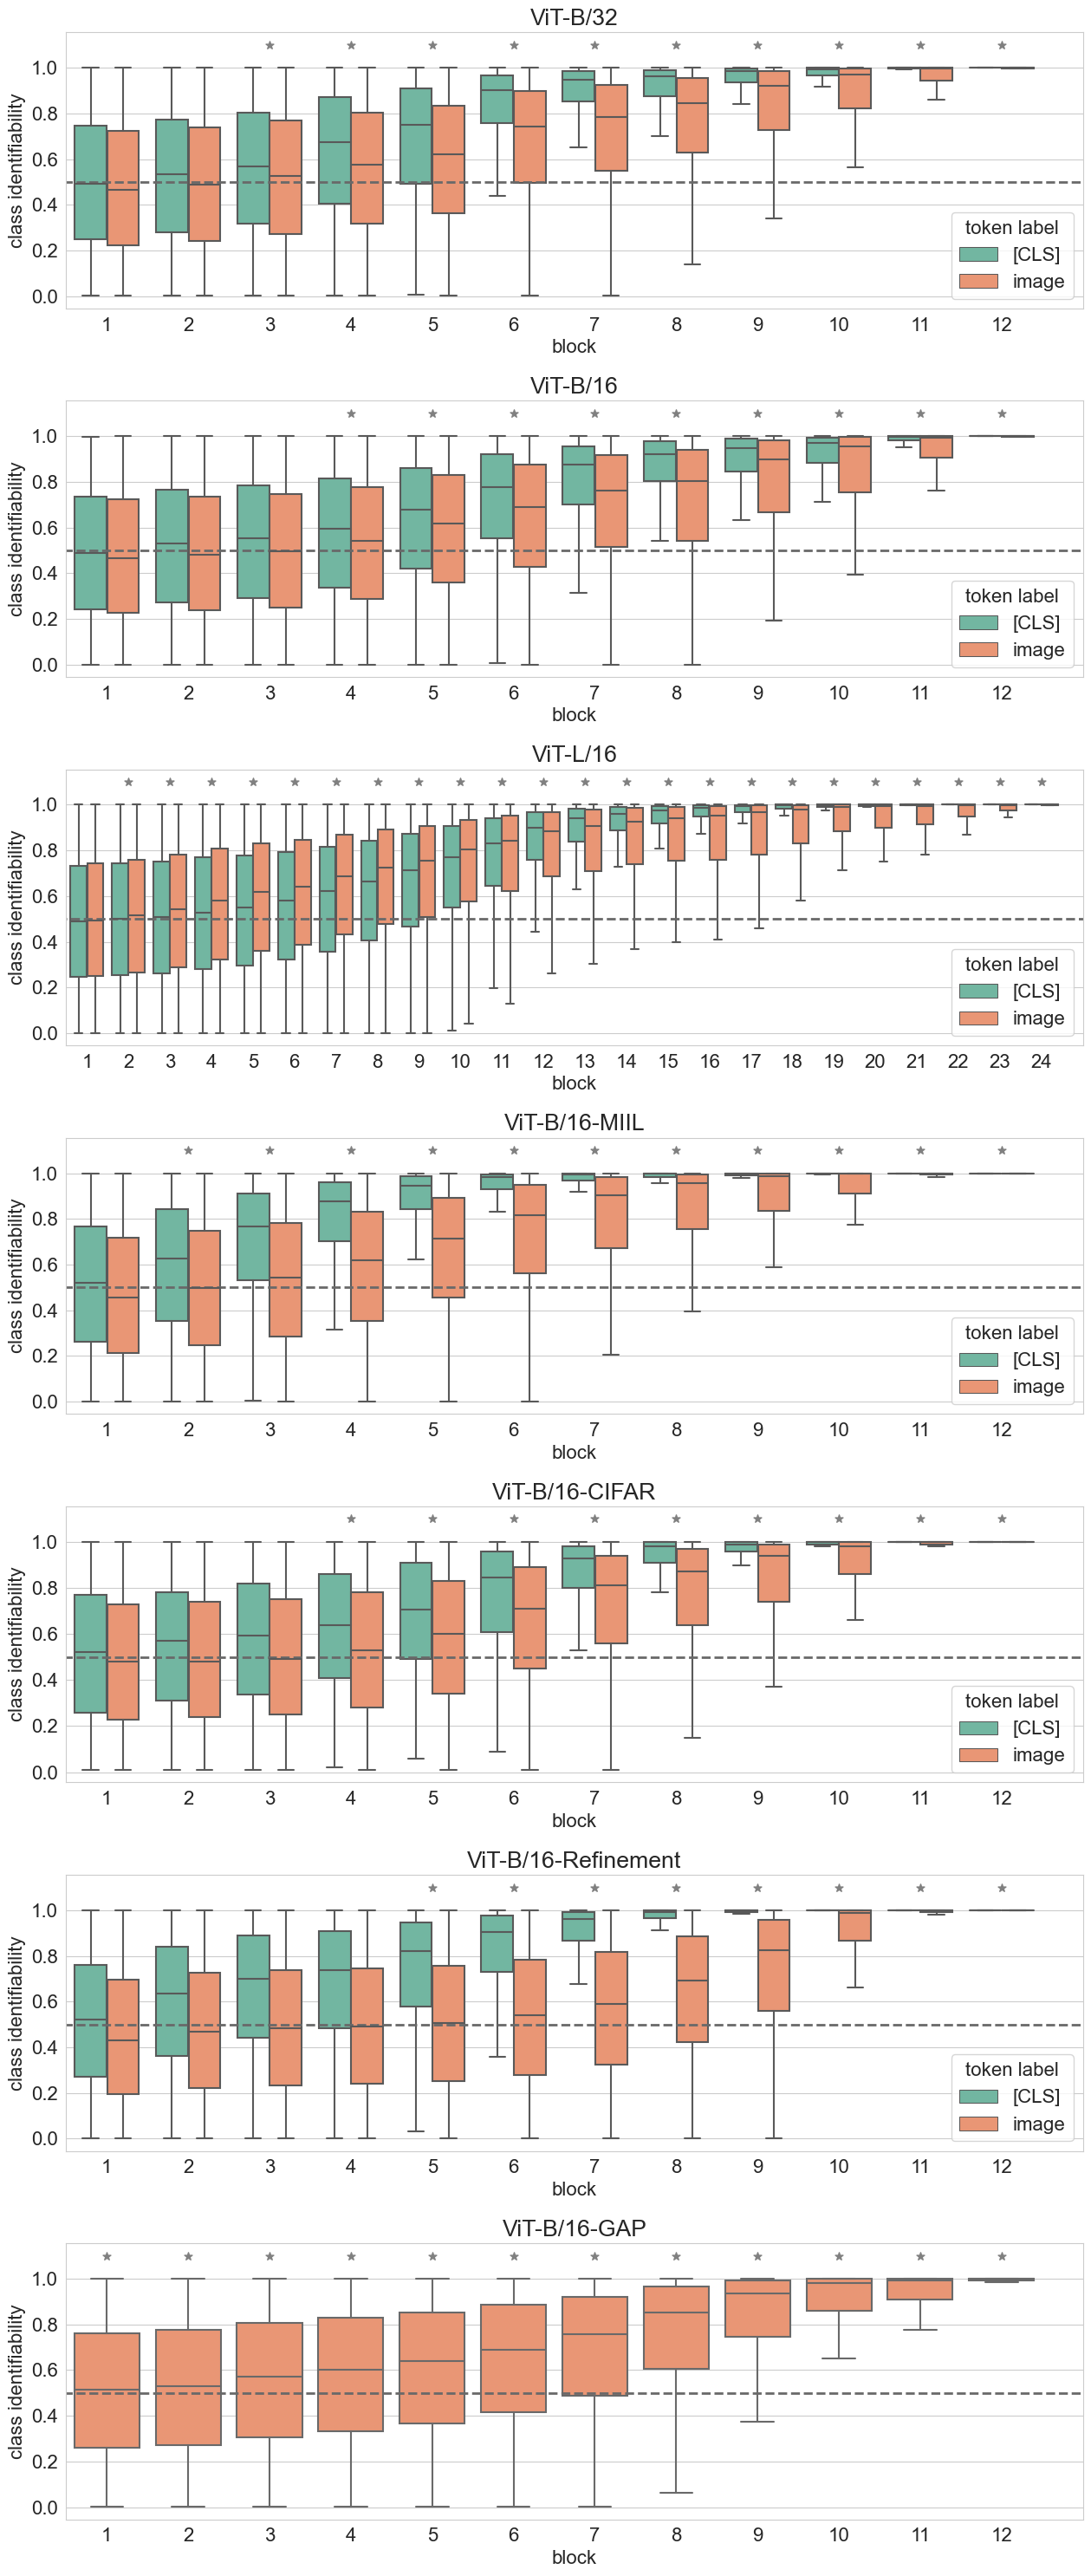

In [17]:
from src.plots.class_ident import plot_identifiability_evolution

plot_identifiability_evolution(RES_PATH, DATASET_PATH)

#### Comparison of mean identifiability evolution

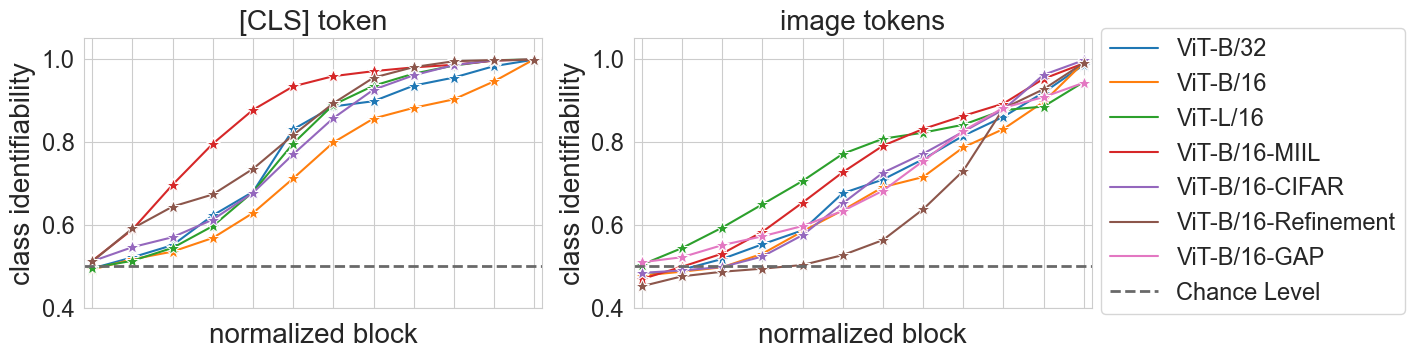

In [7]:
from src.plots.class_ident import compare_identifiability_evolution

compare_identifiability_evolution(RES_PATH, DATASET_PATH, CIFAR_PATH)

### Class similarity change rate

We compute the class similarity change rate of the output image tokens in each block.
Concretely, we quantify the percentage of image tokens that increment the logits of the correct class per block. 

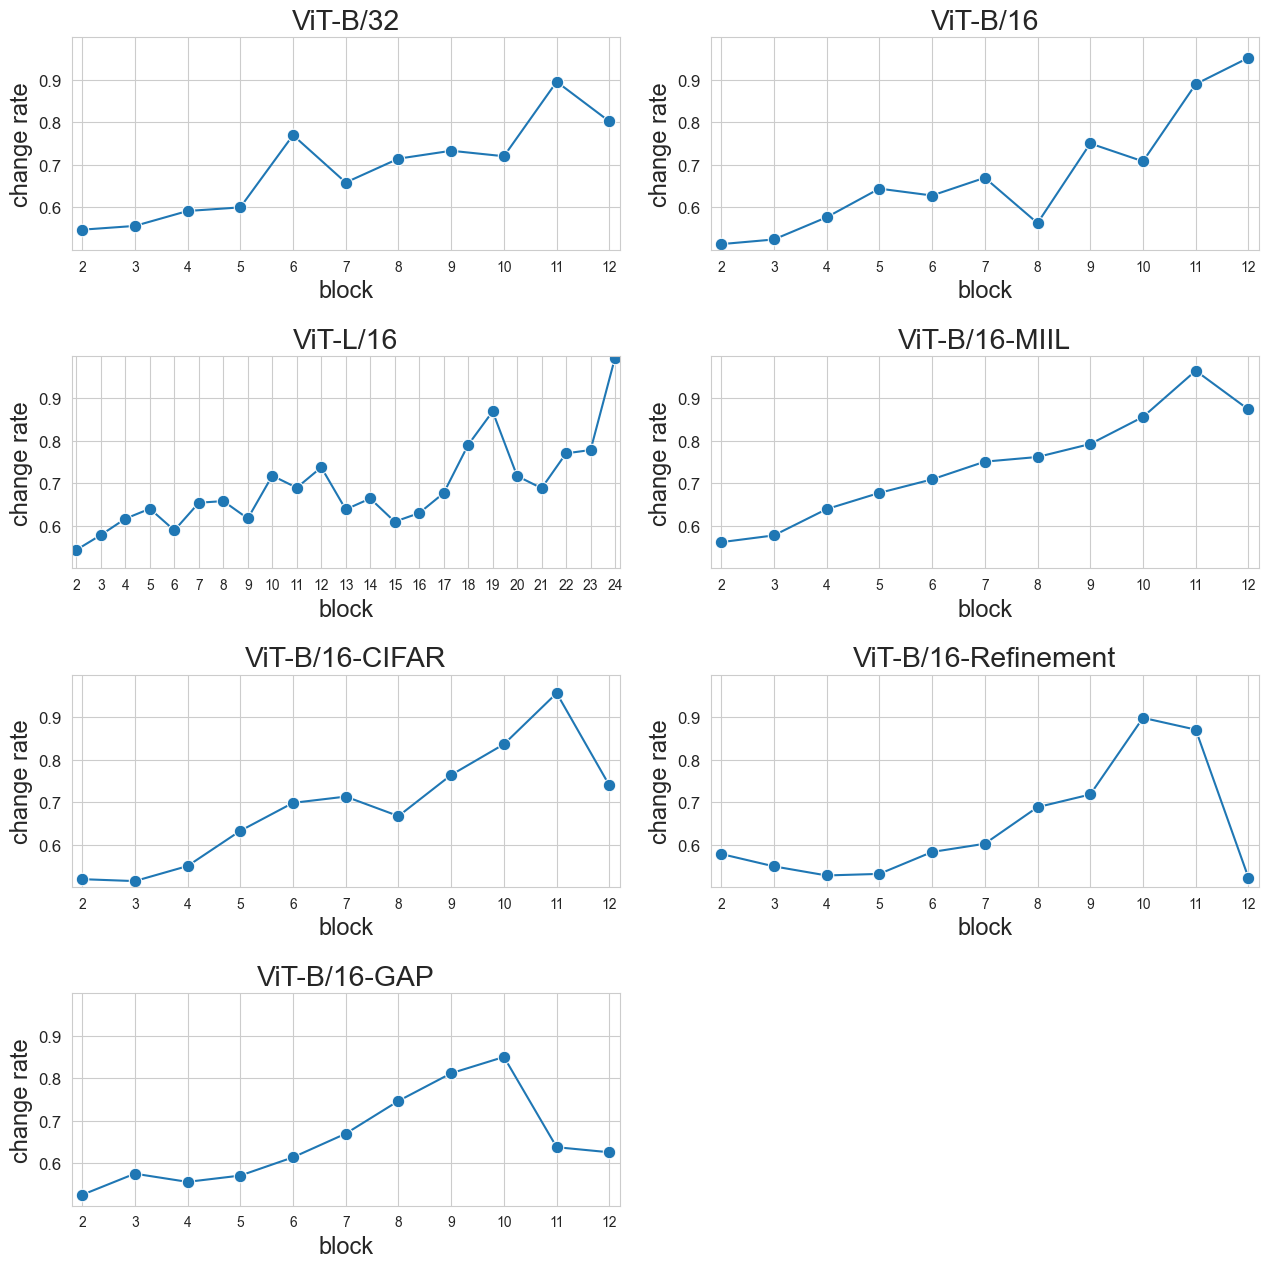

In [9]:
from src.plots.class_ident import plot_logits_increment

plot_logits_increment(RES_PATH, DATASET_PATH)

## The impact of attention mechanisms in the class representations of image tokens

In [11]:
from src.plots.class_ident import print_attn_perturb

### Pertubation studies with only self-attention weights

For the hidden representation of every token $i$ we set to 0 all attention weights from each image token $\mathbf{x}_i$ to every other image token $\{ \mathbf{x}_{j} : j \neq i\}$.

#### ViT-B/32

In [12]:
print_attn_perturb('vit_b_32', 'self_only', RES_PATH, DATASET_PATH)

Class identifiability in self_only: 0.1257142871618271
Class identifiability in unperturbed model: 60.726173400878906


### Perturbation studies with no attention from image tokens to [CLS]

We remove the attention weights between the image tokens and the [CLS] token.

#### ViT-B/32

In [13]:
print_attn_perturb('vit_b_32', 'no_cls', RES_PATH, DATASET_PATH)

Class identifiability in no_cls: 60.71340560913086
Class identifiability in unperturbed model: 60.726173400878906


## The impact of context on the class representations of image tokens

### Difference in identifiability evolution between class- and context-labeled tokens.

We compare the identifiability rate of class-labeled and context-labeled image tokens.

In [14]:
from src.plots.class_ident import plot_context_diff

#### ViT-B/32

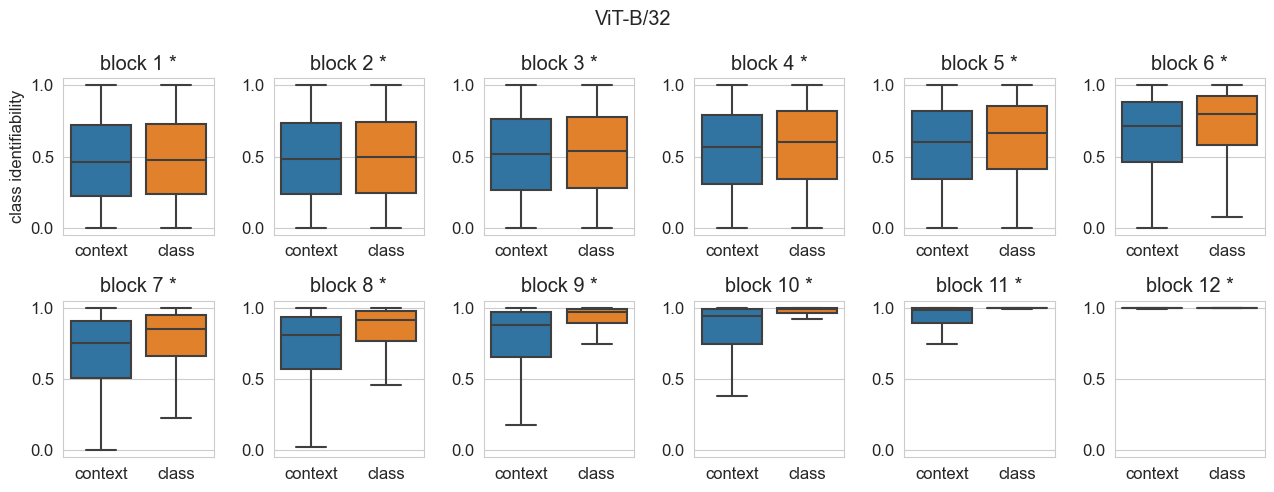

In [15]:
plot_context_diff('vit_b_32', PROJ_PATH, DATASET_PATH)

#### ViT-B/16

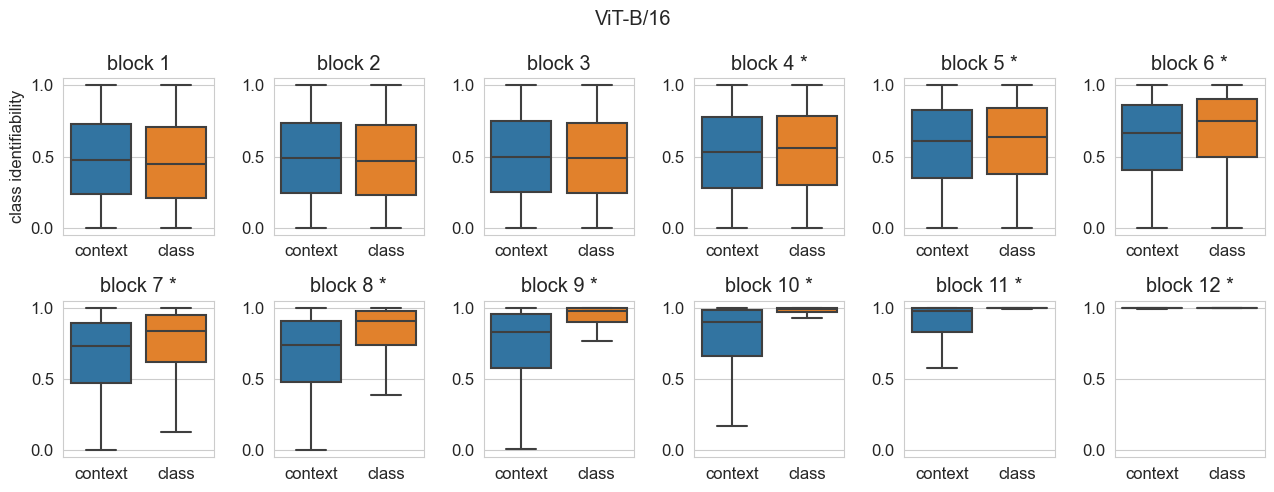

In [16]:
plot_context_diff('vit_b_16', PROJ_PATH, DATASET_PATH)

#### ViT-L/16

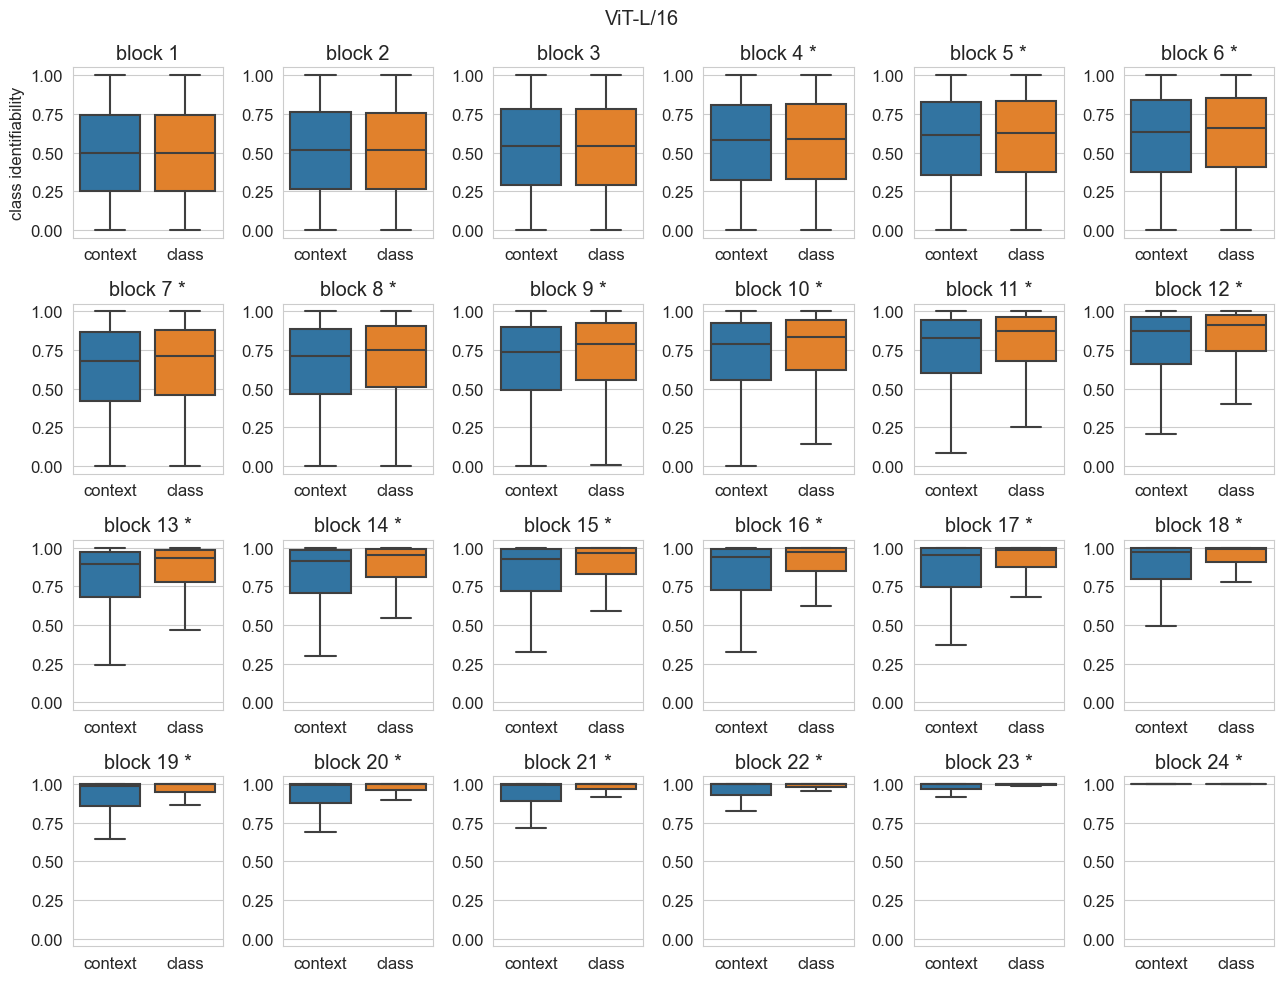

In [17]:
 plot_context_diff('vit_large_16', PROJ_PATH, DATASET_PATH)

#### ViT-B/16 - MIIL 

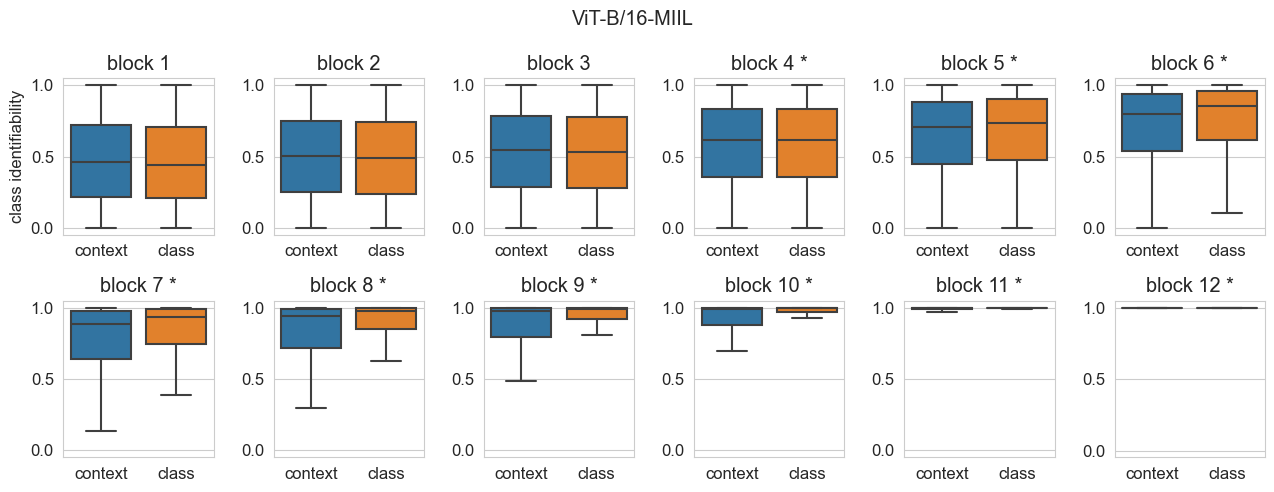

In [18]:
plot_context_diff('vit_miil_16', PROJ_PATH, DATASET_PATH)

#### ViT-B/16 - Refinement

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


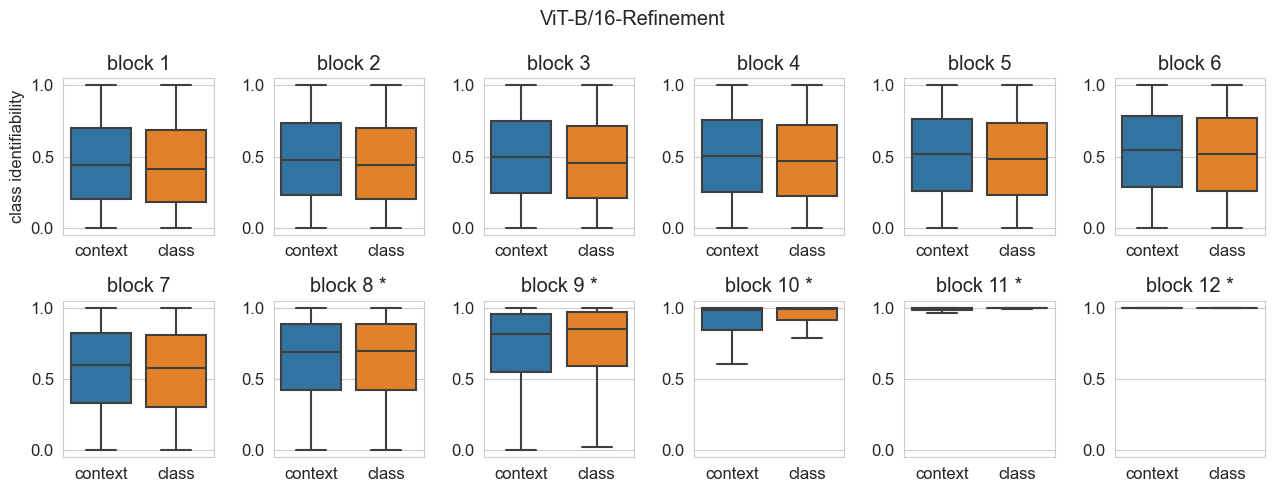

In [19]:
plot_context_diff('deit_ensemble_16', PROJ_PATH, DATASET_PATH)

#### ViT-B/16 - GAP

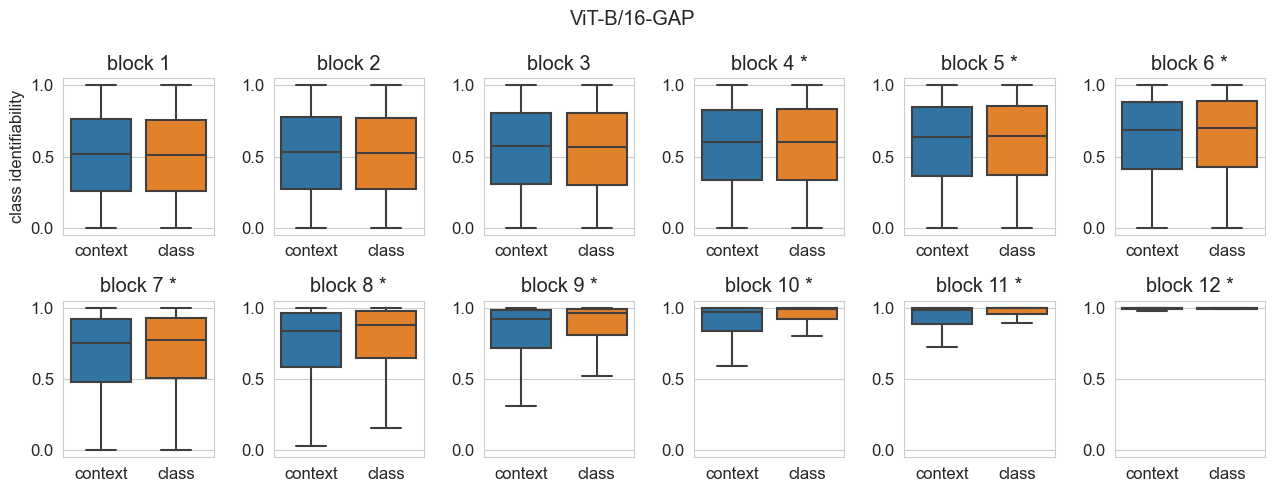

In [20]:
plot_context_diff('vit_gap_16', PROJ_PATH, DATASET_PATH)

### Context perturbation studies

We remove either class- or context-labeled tokens from the input (after the addition of position embeddings), and measure the class-identifiability rates of the remaining image tokens in the last block.

In [21]:
from src.plots.class_ident import print_context_perturb

#### ViT-B/32 and no context-labeled image tokens

In [23]:
print_context_perturb('vit_b_32', 'context', PROJ_PATH, DATASET_PATH)

Class identifiability with no context tokens: 44.70477294921875
Class identifiability in unperturbed model: 71.91523742675781


#### ViT-B/32 and no class-labeled image tokens

In [24]:
print_context_perturb('vit_b_32', 'class_label', PROJ_PATH, DATASET_PATH)

Class identifiability with no class_label tokens: 38.683494567871094
Class identifiability in unperturbed model: 56.24493408203125
